In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import norm

In [63]:
data = pd.read_csv("df_2023-04-11.csv", index_col=0, parse_dates=True)

<AxesSubplot:xlabel='date'>

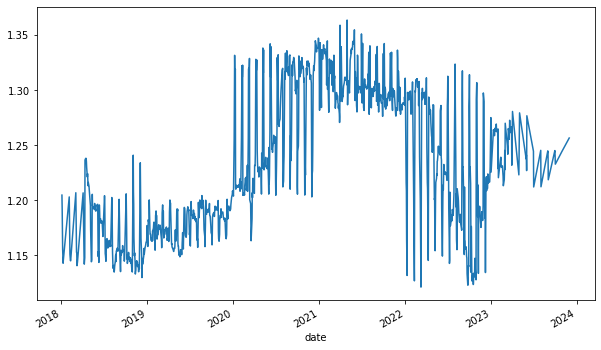

In [65]:
data['TALUSD'] = (1/data['USDCHF'])*100 + (1/data['USDEUR'])*250 + (1/data['USDGBP'])*50 + (1/data['USDJPY'])*18000 + (1/data['USDCNY'])*1600 + (1/data['USDSGD']*80) + ((data['USDGOLD'])*0.2)
data['TALUSD'] = data['TALUSD']*0.001
data['TALUSD'].plot(figsize=(10,6))

In [67]:
currency_columns = ['USDCHF', 'USDEUR', 'USDGBP', 'USDJPY', 'USDCNY', 'USDSGD', 'USDGOLD','TALUSD']
returns = data[currency_columns].pct_change().dropna()


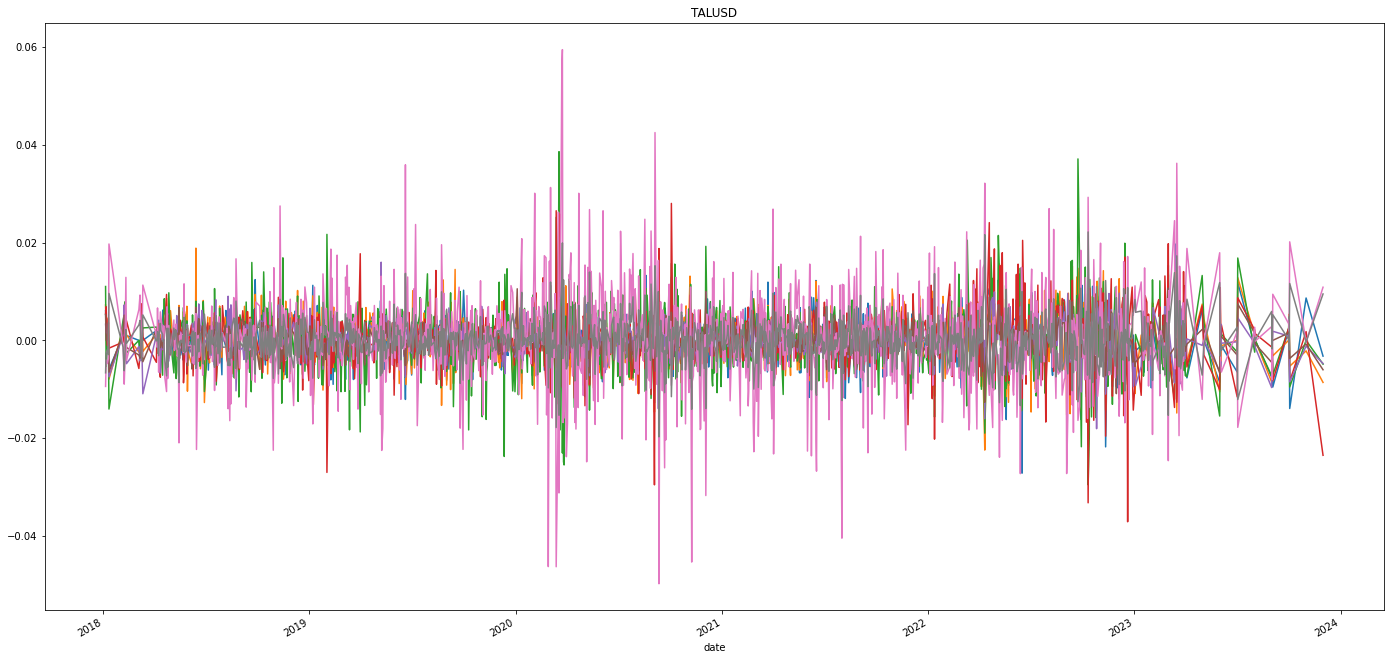

In [68]:
for i in range(0, len(returns.columns)):
    returns[returns.columns[i]].plot(figsize=(24,12), title=returns.columns[i])

In [69]:
def monte_carlo_simulation(returns, num_simulations, num_days):
    # Get the number of currencies
    num_currencies = len(returns.columns)
    
    # Create an empty 3D array to store the results
    results = np.zeros((num_simulations, num_days, num_currencies))

    # Calculate mean and standard deviation for each currency
    means = returns.mean()
    stds = returns.std()

    # Iterate over the number of simulations
    for sim in range(num_simulations):
        # Generate random daily returns from the fitted normal distributions
        random_returns = np.array([norm.rvs(loc=mean, scale=std, size=num_days) for mean, std in zip(means, stds)]).T

        # Calculate the cumulative product of (1 + random_returns)
        cum_random_returns = np.cumprod(1 + random_returns, axis=0)
        
        # Multiply the initial price (1) with the cumulative returns to get the price path
        price_path = cum_random_returns
        
        # Store the price path in the results array
        results[sim, :, :] = price_path

    return results


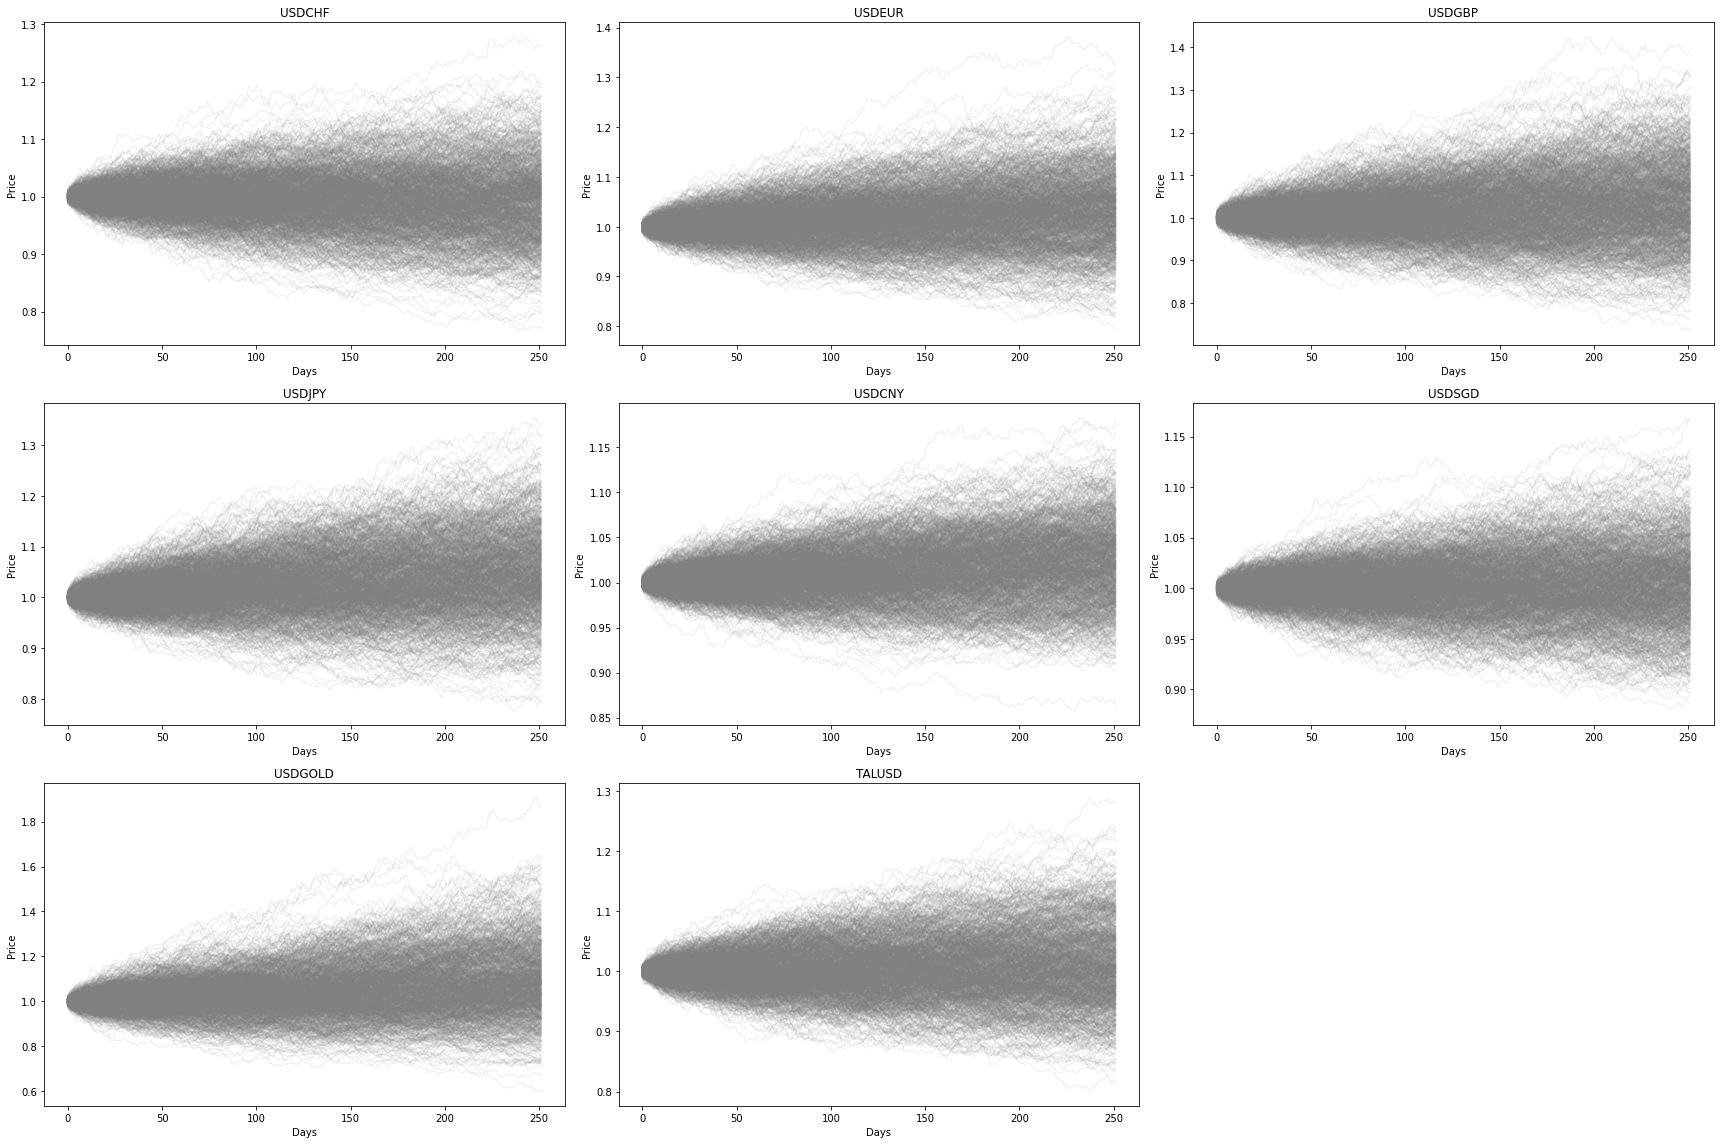

In [70]:
num_simulations = 1000
num_days = 252  # Number of trading days in a year

results = monte_carlo_simulation(returns, num_simulations, num_days)

# Plot the results
plt.figure(figsize=(24, 16))  # Increase the figure size to fit the new currency

for curr_idx, curr_name in enumerate(currency_columns):
    plt.subplot(3, 3, curr_idx + 1)  # Update the subplot layout
    plt.title(curr_name)

    for sim in range(num_simulations):
        plt.plot(results[sim, :, curr_idx], color='grey', alpha=0.1)

    plt.xlabel('Days')
    plt.ylabel('Price')

plt.tight_layout()
plt.show()


  Currency   Mean  Median  Standard Deviation  5th Percentile  95th Percentile
0   USDCHF 0.9881  0.9894              0.0704          0.8760           1.1081
1   USDEUR 1.0303  1.0290              0.0794          0.9078           1.1593
2   USDGBP 1.0328  1.0290              0.1007          0.8734           1.2022
3   USDJPY 1.0473  1.0421              0.0884          0.9072           1.2009
4   USDCNY 1.0215  1.0213              0.0466          0.9480           1.1000
5   USDSGD 1.0034  1.0032              0.0438          0.9324           1.0757
6  USDGOLD 1.0895  1.0802              0.1660          0.8476           1.3847
7   TALUSD 1.0085  1.0039              0.0710          0.8993           1.1318


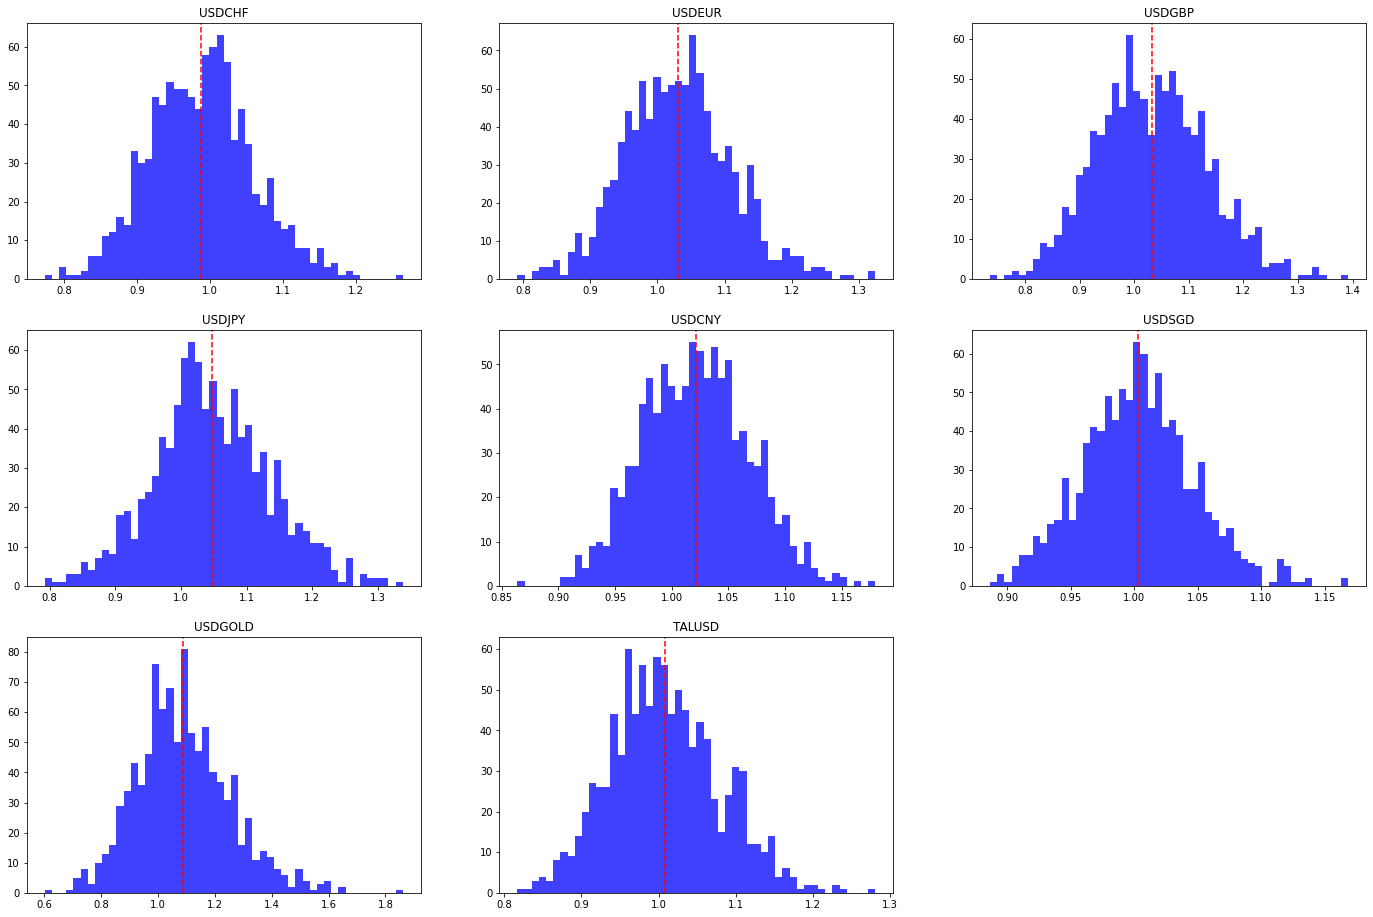

In [71]:
# Calculate the ending prices of each simulation
ending_prices = results[:, -1, :]

# Calculate summary statistics for each currency
mean_ending_prices = np.mean(ending_prices, axis=0)
median_ending_prices = np.median(ending_prices, axis=0)
std_ending_prices = np.std(ending_prices, axis=0)

# Calculate the 5th and 95th percentiles for each currency
percentiles = np.percentile(ending_prices, [5, 95], axis=0)

# Display the summary statistics
summary_statistics = pd.DataFrame({
    'Currency': currency_columns,
    'Mean': mean_ending_prices,
    'Median': median_ending_prices,
    'Standard Deviation': std_ending_prices,
    '5th Percentile': percentiles[0],
    '95th Percentile': percentiles[1],
})

print(summary_statistics)

# Plot the histograms
plt.figure(figsize=(24, 16))  # Increase the figure size to fit the new currency

for curr_idx, curr_name in enumerate(currency_columns):
    plt.subplot(3, 3, curr_idx + 1)  # Update the subplot layout
    plt.title(curr_name)
    plt.hist(ending_prices[:, curr_idx], bins=50, alpha=0.75, color='blue')
    plt.axvline(mean_ending_prices[curr_idx], color='red', linestyle='--', label='Mean')
    plt


In [72]:
stdTAL = returns['TALUSD'].std()
print('Standard Deviation of TAL is: ', stdTAL)

Standard Deviation of TAL is:  0.004285143177710456


In [73]:
def value_at_risk(std, confidence_level, time_horizon):
    return -norm.ppf(1 - confidence_level) * std * np.sqrt(time_horizon)
def expected_shortfall(returns, confidence_level=0.95):
    # Calculate the VaR
    var = -returns.quantile(1 - confidence_level)
    
    # Calculate the Expected Shortfall
    es = -returns[returns < -var].mean()
    
    return es


In [75]:
# Set the VaR parameters
confidence_level = 0.95
time_horizon = 1  # 1-day VaR

# Calculate the VaR
TAL_var = -norm.ppf(1 - confidence_level) * stdTAL * np.sqrt(time_horizon)
print(f"{round(100 * (1 - confidence_level),5)}% 1-day VaR:", TAL_var)
TAL_es = expected_shortfall(returns['TALUSD'], confidence_level)
print(f"Expected Shortfall at {confidence_level * 100}% confidence level:", TAL_es)

5.0% 1-day VaR: 0.0070484332978633995
Expected Shortfall at 95.0% confidence level: 0.00959553976309225


In [76]:
ES = []
for i in currency_columns:
    ES.append(expected_shortfall(returns[i]))

VAR = []
for i in currency_columns:
    VAR.append(value_at_risk(returns[i].std(), confidence_level, time_horizon))

In [77]:
summary_statistics['VaR'] = VAR
summary_statistics['ES'] = ES

In [78]:
summary_statistics.to_csv('montecarlo_statistics.csv')

In [79]:
summary_statistics

,Currency,Mean,Median,Standard Deviation,5th Percentile,95th Percentile,VaR,ES
0,USDCHF,0.9881,0.9894,0.0704,0.8760,1.1081,0.0075,0.0103
1,USDEUR,1.0303,1.0290,0.0794,0.9078,1.1593,0.0079,0.0107
2,USDGBP,1.0328,1.0290,0.1007,0.8734,1.2022,0.0102,0.0140
3,USDJPY,1.0473,1.0421,0.0884,0.9072,1.2009,0.0086,0.0127
4,USDCNY,1.0215,1.0213,0.0466,0.9480,1.1000,0.0048,0.0070
5,USDSGD,1.0034,1.0032,0.0438,0.9324,1.0757,0.0045,0.0060
6,USDGOLD,1.0895,1.0802,0.1660,0.8476,1.3847,0.0157,0.0222
7,TALUSD,1.0085,1.0039,0.0710,0.8993,1.1318,0.0070,0.0096


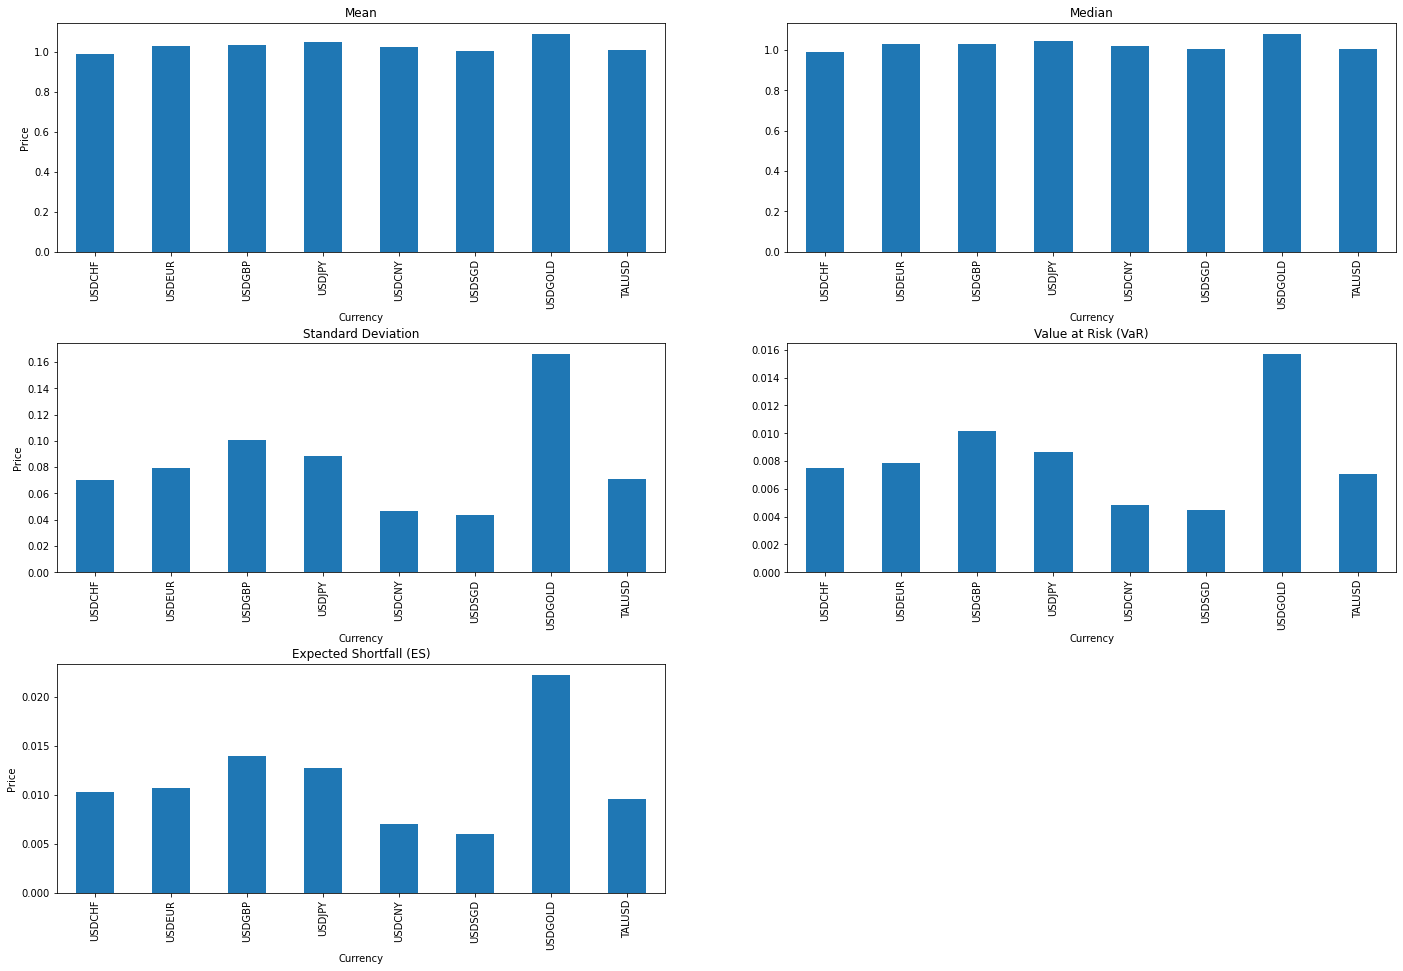

,Currency,Mean,Median,Standard Deviation,5th Percentile,95th Percentile,VaR,ES
0,USDCHF,0.9881,0.9894,0.0704,0.8760,1.1081,0.0075,0.0103
1,USDEUR,1.0303,1.0290,0.0794,0.9078,1.1593,0.0079,0.0107
2,USDGBP,1.0328,1.0290,0.1007,0.8734,1.2022,0.0102,0.0140
3,USDJPY,1.0473,1.0421,0.0884,0.9072,1.2009,0.0086,0.0127
4,USDCNY,1.0215,1.0213,0.0466,0.9480,1.1000,0.0048,0.0070
5,USDSGD,1.0034,1.0032,0.0438,0.9324,1.0757,0.0045,0.0060
6,USDGOLD,1.0895,1.0802,0.1660,0.8476,1.3847,0.0157,0.0222
7,TALUSD,1.0085,1.0039,0.0710,0.8993,1.1318,0.0070,0.0096


In [80]:
stats_df = pd.DataFrame(summary_statistics)

# Plot bar charts for Mean, Median, Standard Deviation, VaR, and ES
fig, axes = plt.subplots(3, 2, figsize=(24, 16))
fig.subplots_adjust(hspace=0.4)

stats_df.plot(x="Currency", y="Mean", kind="bar", ax=axes[0, 0], legend=False)
axes[0, 0].set_title("Mean")
axes[0, 0].set_ylabel("Price")

stats_df.plot(x="Currency", y="Median", kind="bar", ax=axes[0, 1], legend=False)
axes[0, 1].set_title("Median")

stats_df.plot(x="Currency", y="Standard Deviation", kind="bar", ax=axes[1, 0], legend=False)
axes[1, 0].set_title("Standard Deviation")
axes[1, 0].set_ylabel("Price")

stats_df.plot(x="Currency", y="VaR", kind="bar", ax=axes[1, 1], legend=False)
axes[1, 1].set_title("Value at Risk (VaR)")

stats_df.plot(x="Currency", y="ES", kind="bar", ax=axes[2, 0], legend=False)
axes[2, 0].set_title("Expected Shortfall (ES)")
axes[2, 0].set_ylabel("Price")


axes[2, 1].set_visible(False)

plt.show()

pd.set_option("display.float_format", "{:.4f}".format)
display(stats_df)